In [1]:
from RDetector import *
import pandas as pd
import numpy as np
import torch
import os
from tqdm import tqdm

NAME='Bittium_I'

# Learning Track

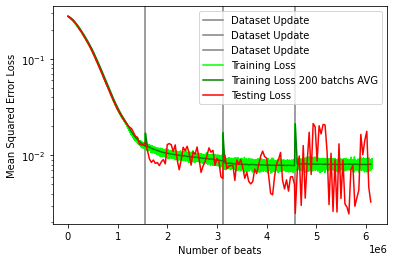

In [2]:
# New version
# Check total training curve
total_loss = pd.read_csv('Model/Total_Loss_Track_{}.csv'.format(NAME), sep=',', header=None).to_numpy()
batch_track = pd.read_csv('Model/Batch_AVG_Loss_Track_{}.csv'.format(NAME), sep=',', header=None).to_numpy()

# Add epoch bar
color_arr = ['goldenrod', 'indigo', 'darkcyan', 'darkkhaki']
tmp = 0
for i in range(0, total_loss.shape[0]):
    if total_loss[i, 0] != tmp:
        tmp = total_loss[i, 0]
        plt.axvline(x=total_loss[i, 1]*200, color='gray', label='Dataset Update')
        
plt.plot(total_loss[:, 1]*200, total_loss[:, 2], color='lime', label='Training Loss')
plt.plot(batch_track[:, 1]*200, batch_track[:, 2], color='green', label='Training Loss 200 batchs AVG')
plt.plot(batch_track[:, 1]*200, batch_track[:, 3], color='red', label='Testing Loss')
plt.yscale('log')
plt.xlabel('Number of beats')
plt.ylabel('Mean Squared Error Loss')
plt.legend()
plt.show()
#plt.savefig('figs/R_detect_TriningLoss.png')
plt.close()

In [3]:
# Load the best model
device = 'cuda:0'
model = RDetector(name=NAME).to(device)
model.restore()

# Opening edf file

In [ ]:
import pyedflib
# path to the target file
file_path = 'D:/ECG/ECG_DATABASE_A/Segmented/0a52689a6d49493ebda67374e3ebdd31_2.edf'
# Read the file
signal, signal_headers, header = pyedflib.highlevel.read_edf(file_path)

# Extract a sub_signal 
start = 10000
# 60 min signal
end = start + (30 * 60 * 250)
sample = signal[:, start:end]
print(sample.shape)

# R annotations of the signal

In [ ]:
# Annot the file
annot_sign, annot_idx = model.annot_peaks(sample, device=device, pre_trait=False)

# Comparison plot for report

IDX: 194283


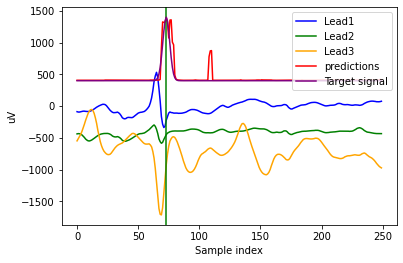

In [7]:
import random
import scipy.stats as stats

tmp_x = np.arange(0, 1000)
r_box = stats.norm.pdf(tmp_x, 500, math.sqrt(8))
r_box *= (1 / np.max(r_box))

start = random.randint(0, sample.shape[1]-250)
start = 194283
print('IDX: {}'.format(start))
size = 250
end = start + size

x = range(size)

plt.plot(x, sample[0, start:end], color='blue', label='Lead1')
plt.plot(x, sample[1, start:end]-400, color='green', label='Lead2')
plt.plot(x, sample[2, start:end]-800, color='orange', label='Lead3')
plt.plot(x, (annot_sign[start:end]*2000) + 400, color='red', label='predictions')

target_line = np.zeros(size)

for itm in annot_idx:
    if itm > end:
        break
    if itm > start:
        idx = itm-start
        plt.axvline(x=itm-start, c='green')
        plt.plot(x, (r_box[500-idx:500-idx+size]*1000)+400, c='purple', label='Target signal')

plt.legend(loc='upper right')
plt.xlabel('Sample index')
plt.ylabel('uV')
#plt.savefig('figs/r_annot_signal_demo.png')
plt.show()
plt.close()

# Export data to an EDF file

In [16]:
# Get annotations
total = []
for itm in annot_idx:
    tmp = [itm/250, 1, 'N']
    total.append(tmp)
new_signal = np.zeros((sample.shape[0]+1, sample.shape[1]))
new_signal[0:sample.shape[0], :] = sample
new_signal[sample.shape[0], :] = annot_sign * 1000
# Get new signal header for R confidence
new_head = signal_headers
tmp_head = new_head[0]
tmp_head['label'] = 'R-CONF'
new_head.append(tmp_head)
header['annotations'] = total
pyedflib.highlevel.write_edf('Outputs/test_I.edf', new_signal, new_head, header)

True

In [8]:
test = torch.load('D:/ECG/ECG_DATABASE_A/Seg_beat_tensor/02551213c55d45a594a47e74d9581398_10_2.pt')
test = torch.stack(test)
print(test.size())
        


torch.Size([2508, 2, 350])


# Test on MIT-BIH

In [10]:
import wfdb
import Utils
file_path = 'D:/ECG/mit/113'
signal = wfdb.rdrecord(file_path)
signal = signal.p_signal.T
signal = Utils.filtering(signal, freq_adapter=True)
signal *= 1000



In [11]:
annot_sign, r = model.annot_peaks(signal, pre_trait=False)

100%|███████████████████████████████████████████████████████████████████████| 451388/451388 [00:08<00:00, 51782.27it/s]


In [12]:
# Export
total = []
for itm in r:
    tmp = [itm/250, 1, 'N']
    total.append(tmp)
new_signal = np.zeros((signal.shape[0]+1, signal.shape[1]))
new_signal[0:signal.shape[0], :] = signal
new_signal[signal.shape[0], :] = annot_sign * 1000
# Get new signal header for R confidence
new_headers = [{'label': 'R-CONF',
  'dimension': 'uV',
  'sample_rate': 250,
  'physical_max': 32767.0,
  'physical_min': -32768.0,
  'digital_max': 32767,
  'digital_min': -32768,
  'prefilter': '',
  'transducer': ''},
 {'label': 'ECG_2',
  'dimension': 'uV',
  'sample_rate': 250,
  'physical_max': 32767.0,
  'physical_min': -32768.0,
  'digital_max': 32767,
  'digital_min': -32768,
  'prefilter': '',
  'transducer': ''},
 {'label': 'ECG_3',
  'dimension': 'uV',
  'sample_rate': 250,
  'physical_max': 32767.0,
  'physical_min': -32768.0,
  'digital_max': 32767,
  'digital_min': -32768,
  'prefilter': '',
  'transducer': ''}]

header['annotations'] = total
pyedflib.highlevel.write_edf('Outputs/test_MIT.edf', new_signal, new_headers, header)

True

In [13]:
header

{'technician': '',
 'recording_additional': '',
 'patientname': 'X',
 'patient_additional': '',
 'patientcode': '',
 'equipment': '',
 'admincode': '',
 'gender': '',
 'startdate': datetime.datetime(2020, 9, 22, 9, 32, 35),
 'birthdate': '',
 'annotations': [[0.492, 1, 'N'],
  [1.648, 1, 'N'],
  [2.716, 1, 'N'],
  [3.728, 1, 'N'],
  [4.756, 1, 'N'],
  [5.852, 1, 'N'],
  [6.992, 1, 'N'],
  [8.008, 1, 'N'],
  [9.048, 1, 'N'],
  [10.164, 1, 'N'],
  [11.172, 1, 'N'],
  [12.116, 1, 'N'],
  [13.084, 1, 'N'],
  [14.14, 1, 'N'],
  [15.176, 1, 'N'],
  [16.076, 1, 'N'],
  [17.136, 1, 'N'],
  [18.312, 1, 'N'],
  [19.4, 1, 'N'],
  [20.376, 1, 'N'],
  [21.504, 1, 'N'],
  [22.564, 1, 'N'],
  [23.508, 1, 'N'],
  [24.04, 1, 'N'],
  [25.16, 1, 'N'],
  [26.28, 1, 'N'],
  [27.328, 1, 'N'],
  [28.356, 1, 'N'],
  [29.412, 1, 'N'],
  [30.544, 1, 'N'],
  [31.66, 1, 'N'],
  [32.636, 1, 'N'],
  [33.692, 1, 'N'],
  [34.732, 1, 'N'],
  [35.788, 1, 'N'],
  [36.808, 1, 'N'],
  [37.832, 1, 'N'],
  [38.868, 1, 'N'],